# Figure 4 (NLP 2023.6)

In [1]:
import os
import numpy as np
import pickle

from config import MRI8_NVF4_10mm_0p0mmVVVV as cfg

os.chdir('../')
from lib.methods import *
from lib.figure import NLP

os.chdir('../')

2023-05-22 14:33:25.687047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [2]:
csv_data_list, video_data_list, video_t_data_list = LoadCSVandVIDEOS(
                                                                    csv_path=cfg.CSV_FILE_DIR+cfg.DATA_NAME+cfg.CSV_ADDITIONAL_PATH+'.csv', 
                                                                    data_name_list=['t', 'mic', 'flow'], 
                                                                    sample_span=cfg.SAMPLE_SPAN, 
                                                                    videos_path_list=[
                                                                                    cfg.VIDEO_FILE_DIR+'VF/'+cfg.DATA_NAME+'.avi',
                                                                                    cfg.VIDEO_FILE_DIR+'FVF/'+cfg.DATA_NAME+'.avi',
                                                                                    ]
                                                                    )

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI8_NVF4_10mm_0p0mmVVVV.csv
data list | t, mic, flow
Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/VF/MRI8_NVF4_10mm_0p0mmVVVV.avi


Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/FVF/MRI8_NVF4_10mm_0p0mmVVVV.avi


## Pre-process

In [3]:
PP = PreProcessing(
                data=csv_data_list[1], ### mic data
                t_data=csv_data_list[0], ### mic t data
                video_data_list=video_data_list, 
                video_t_data_list=video_t_data_list
                )
PP.filter()
PP.linescanning_video(params_list=[cfg.LINE_SCANNING_PARAMS_VF, cfg.LINE_SCANNING_PARAMS_FVF])

mic_data = PP.data
mic_t_data = PP.t_data
video_data_list = PP.video_data_list
video_t_list = PP.video_t_data_list

flow_data = csv_data_list[2]
video_vf_data = video_data_list[0]
video_fvf_data = video_data_list[1]
video_t_data = video_t_data_list[0]

## Load latent vector data

In [4]:
latent_vector_vf = pickle.load(open(cfg.LV_DIR+cfg.DATA_NAME+'_vf.pkl', 'rb'))
latent_vector_fvf = pickle.load(open(cfg.LV_DIR+cfg.DATA_NAME+'_fvf.pkl', 'rb'))

## Bifurcation convert

In [6]:
BC_vf = BifurcationConvert(data=latent_vector_vf, parameter_data=flow_data, t_data=video_t_data)
BC_vf.convert(params = cfg.BF_CONVERT_PARAMS)
BC_vf.discretization(params = cfg.BF_DISCRETIZATION_PARAMS_VF)
param_lim = cfg.SINDY_PARAM_LIM
bifurcation_parameter_vf_list = BC_vf.bifurcation_parameter_list[param_lim[0]:param_lim[-1]]
bifurcation_data_vf_list = BC_vf.bifurcation_data_list[param_lim[0]:param_lim[-1]]
bifurcation_t_data_vf_list = BC_vf.bifurcation_t_data_list[param_lim[0]:param_lim[-1]]
bifurcation_data_vf_list_discreted = BC_vf.bifurcation_data_list_discreted[param_lim[0]:param_lim[-1]]
bifurcation_data_vf_list_discreted_index = BC_vf.bifurcation_data_list_discreted_index[param_lim[0]:param_lim[-1]]

BC_vf = BifurcationConvert(data=video_vf_data, parameter_data=flow_data, t_data=video_t_data)
BC_vf.convert(params={ 'parameter_sample_step': 1000,'standardize': False, 'mean0':False })
bifurcation_video_data_vf_list = BC_vf.bifurcation_data_list[param_lim[0]:param_lim[-1]]

BC_fvf = BifurcationConvert(data=latent_vector_fvf, parameter_data=flow_data, t_data=video_t_data)
BC_fvf.convert(params = cfg.BF_CONVERT_PARAMS)
BC_fvf.discretization(params = cfg.BF_DISCRETIZATION_PARAMS_FVF)
param_lim = cfg.SINDY_PARAM_LIM
bifurcation_parameter_fvf_list = BC_fvf.bifurcation_parameter_list[param_lim[0]:param_lim[-1]]
bifurcation_data_fvf_list = BC_fvf.bifurcation_data_list[param_lim[0]:param_lim[-1]]
bifurcation_t_data_fvf_list = BC_fvf.bifurcation_t_data_list[param_lim[0]:param_lim[-1]]
bifurcation_data_fvf_list_discreted = BC_fvf.bifurcation_data_list_discreted[param_lim[0]:param_lim[-1]]
bifurcation_data_fvf_list_discreted_index = BC_fvf.bifurcation_data_list_discreted_index[param_lim[0]:param_lim[-1]]

BC_fvf = BifurcationConvert(data=video_fvf_data, parameter_data=flow_data, t_data=video_t_data)
BC_fvf.convert(params={ 'parameter_sample_step': 1000,'standardize': False, 'mean0':False })
bifurcation_video_data_fvf_list = BC_fvf.bifurcation_data_list[param_lim[0]:param_lim[-1]]

## Figure

In [77]:
class NLP_p():

    def __init__(self, rcParams_dict):
        for key in rcParams_dict.keys():
            plt.rcParams[str(key)] = rcParams_dict[str(key)]   

    def figure(self, 
                scanned_video, latent_vector, latent_vector_discreted, latent_vector_discreted_idx, t,
                figsize=(25, 5), height_ratios=[1, 1], hspace=0.5,
                title=None, title_loc='left',
                aspect=0.9, gamma=0.3, ylabel1='Pixel', tick_x_c_white=False,
                lw_lv=3, c_lv='k', label_lv='Latent vector',
                plt_lm=True, marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', legend=False, xlabel2='Time [ms]', ylabel2=r'$y(t)$',
                save_png=None, save_eps=None):
            
            spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=height_ratios, hspace=hspace)
            fig = plt.figure(figsize=figsize)

            scanned_video = gamma_correction(scanned_video, gamma)

            ax1 = fig.add_subplot(spec[0])
            ax1.set_title(title, loc=title_loc)
            ax1.imshow(scanned_video.T, cmap='Greys_r', norm=Normalize(vmin=0, vmax=255), aspect=aspect)
            ax1.set_ylabel(ylabel1)
            ax1.tick_params(labelleft=False, left=False, labelbottom=False, bottom=True)
            if tick_x_c_white:
                ax1.tick_params(axis='x', colors='white')

            ax2 = fig.add_subplot(spec[1], xmargin=0)
            ax2.plot((t-t[0])*1000, latent_vector, lw=lw_lv, c=c_lv, label=label_lv)
            if plt_lm:
                ax2.plot(((t-t[0])[latent_vector_discreted_idx])*1000, latent_vector_discreted, linestyle='None', lw=0, c=c_lv_lm, marker=marker_lv_lm, markersize=s_lv_lm, label=label_lv_lm)
            ax2.set_ylabel(ylabel2)
            ax2.set_xlabel(xlabel2)
            ax2.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%d'))
            ax2.tick_params(labelleft=False, left=False, labelbottom=True, bottom=True)
            if legend:
                ax2.legend(frameon=False)

            plt.tight_layout()
            if save_png==None:
                plt.show()
            else:
                plt.savefig(save_png+'.png', bbox_inches="tight")
            if save_png==None:
                return
            else:
                plt.savefig(save_eps+'.eps', bbox_inches="tight")

39.62269287109375


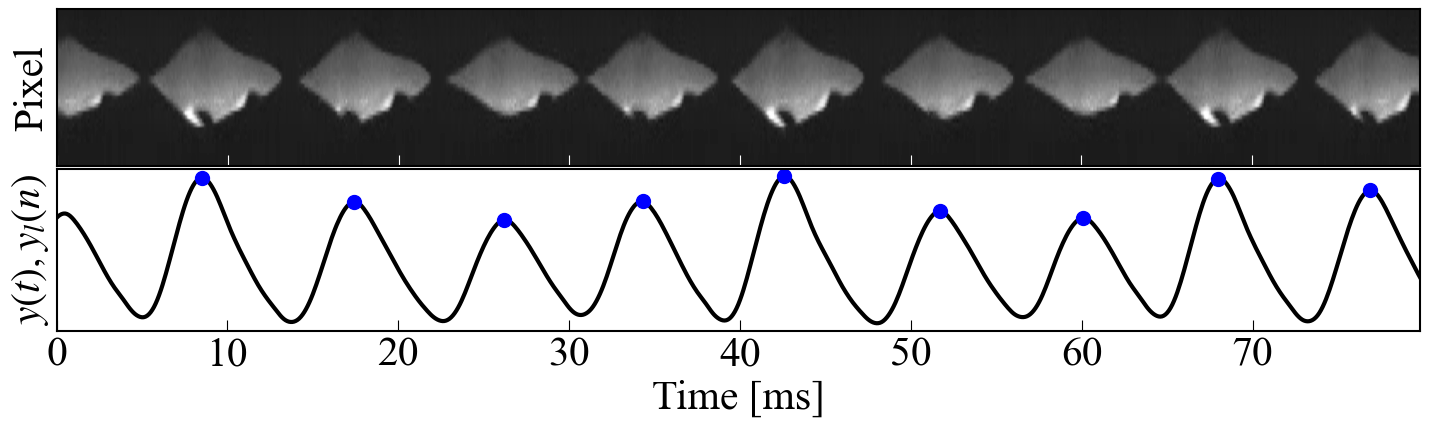

40.061975097656244


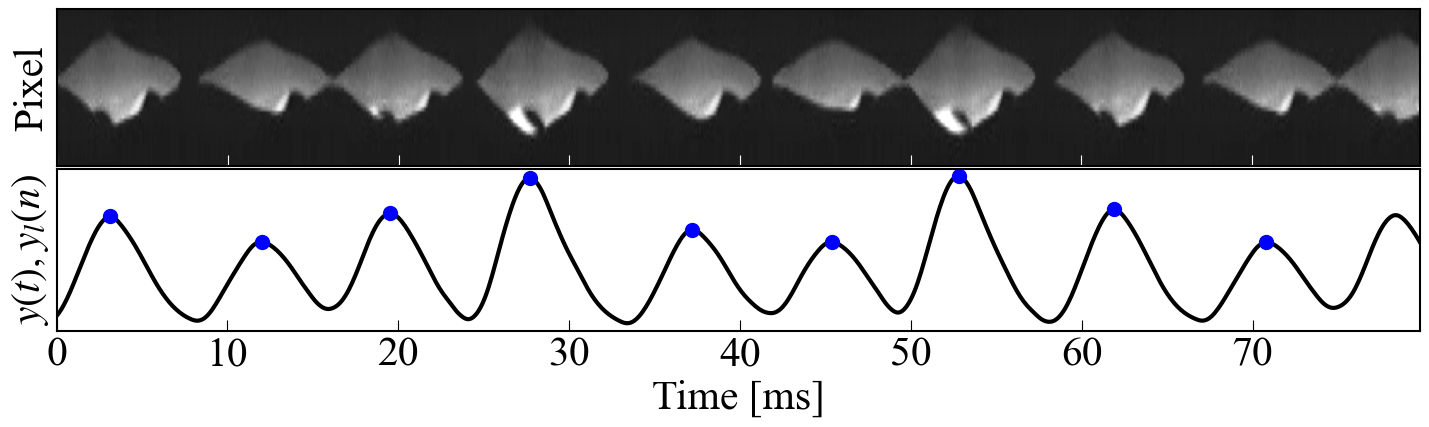

In [76]:
fig = NLP_p({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            'xtick.direction':'in',
            'ytick.direction':'in',
            'axes.linewidth':1.5,
            'xtick.major.size':8,
            'ytick.major.size':8,
            })

param_num = 30
print(bifurcation_parameter_vf_list[param_num]*40.)
fig.figure(scanned_video=bifurcation_video_data_vf_list[param_num],  
           latent_vector=bifurcation_data_vf_list[param_num], 
           latent_vector_discreted=bifurcation_data_vf_list_discreted[param_num],
           latent_vector_discreted_idx=bifurcation_data_vf_list_discreted_index[param_num], 
           t=bifurcation_t_data_vf_list[param_num],
            figsize=(15, 5), height_ratios=[1, 1], hspace=0.0, 
            title=None, title_loc='left',
            aspect=2.3, gamma=0.8, ylabel1='Pixel', tick_x_c_white=True,
            lw_lv=3, c_lv='k', label_lv='Latent vector',
            marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', legend=False, xlabel2='Time [ms]', ylabel2=r'$y(t), y_l(n)$',
            save_png=None, save_eps=None)

param_num = -1
print(bifurcation_parameter_vf_list[param_num]*40.)
fig.figure(scanned_video=bifurcation_video_data_vf_list[param_num],  
           latent_vector=bifurcation_data_vf_list[param_num], 
           latent_vector_discreted=bifurcation_data_vf_list_discreted[param_num],
           latent_vector_discreted_idx=bifurcation_data_vf_list_discreted_index[param_num], 
           t=bifurcation_t_data_vf_list[param_num],
            figsize=(15, 5), height_ratios=[1, 1], hspace=0.0, 
            title=None, title_loc='left',
            aspect=2.3, gamma=0.8, ylabel1='Pixel', tick_x_c_white=True,
            lw_lv=3, c_lv='k', label_lv='Latent vector',
            marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', legend=False, xlabel2='Time [ms]', ylabel2=r'$y(t), y_l(n)$',
            save_png=None, save_eps=None)

40.061975097656244


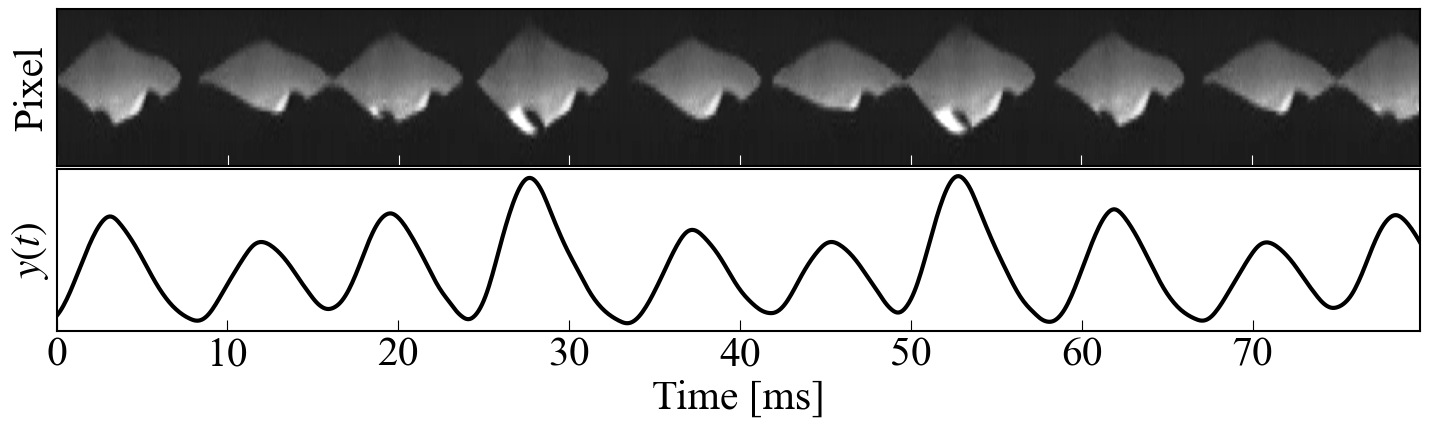

40.061975097656244


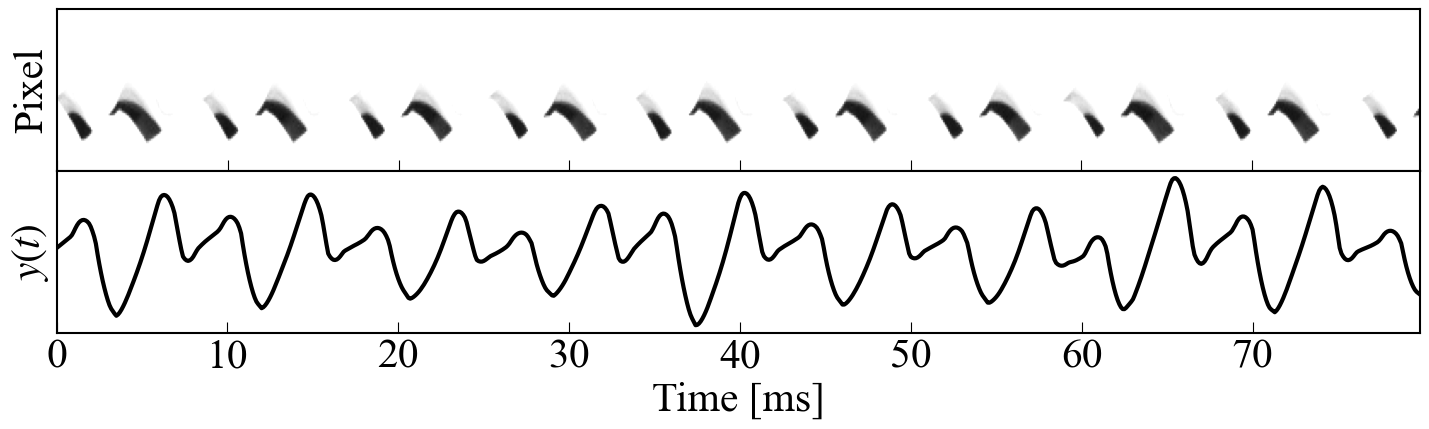

In [83]:
param_num = -1
print(bifurcation_parameter_vf_list[param_num]*40.)
fig.figure(scanned_video=bifurcation_video_data_vf_list[param_num],  
           latent_vector=bifurcation_data_vf_list[param_num], 
           latent_vector_discreted=bifurcation_data_vf_list_discreted[param_num],
           latent_vector_discreted_idx=bifurcation_data_vf_list_discreted_index[param_num], 
           t=bifurcation_t_data_vf_list[param_num],
            figsize=(15, 5), height_ratios=[1, 1], hspace=0.0, 
            title=None, title_loc='left',
            aspect=2.3, gamma=0.8, ylabel1='Pixel', tick_x_c_white=True,
            lw_lv=3, c_lv='k', label_lv='Latent vector',
            plt_lm=False, marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', legend=False, xlabel2='Time [ms]', ylabel2=r'$y(t)$',
            save_png=None, save_eps=None)

param_num = -1
print(bifurcation_parameter_fvf_list[param_num]*40.)
fig.figure(scanned_video=bifurcation_video_data_fvf_list[param_num],  
           latent_vector=bifurcation_data_fvf_list[param_num], 
           latent_vector_discreted=bifurcation_data_fvf_list_discreted[param_num],
           latent_vector_discreted_idx=bifurcation_data_fvf_list_discreted_index[param_num], 
           t=bifurcation_t_data_fvf_list[param_num],
            figsize=(15, 5), height_ratios=[1, 1], hspace=0.0, 
            title=None, title_loc='left',
            aspect=1.35, gamma=0.8, ylabel1='Pixel', tick_x_c_white=False,
            lw_lv=3, c_lv='k', label_lv='Latent vector',
            plt_lm=False, marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', legend=False, xlabel2='Time [ms]', ylabel2=r'$y(t)$',
            save_png=None, save_eps=None)

40.061975097656244


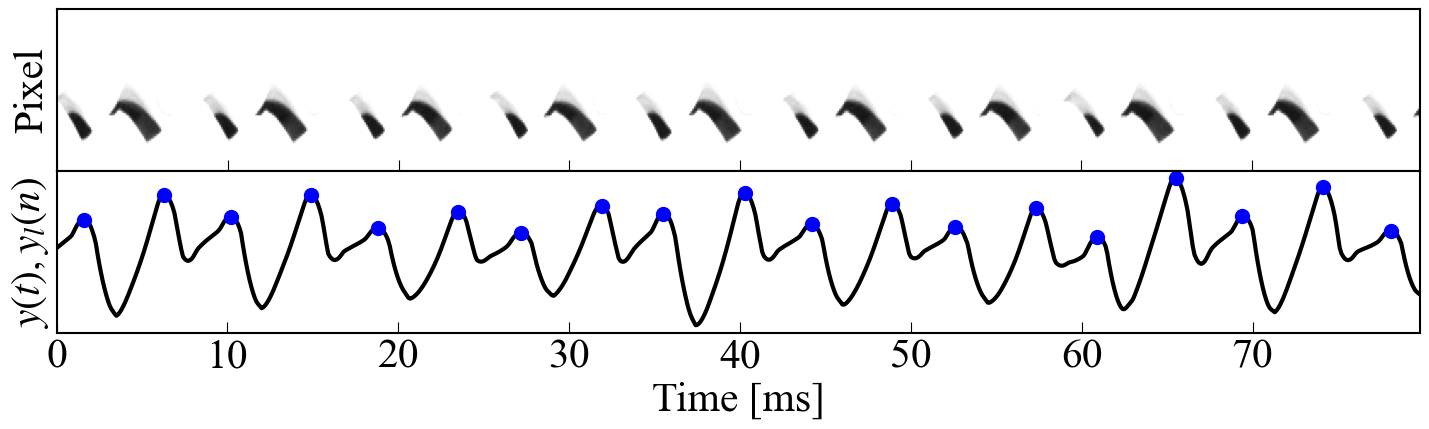

In [72]:
param_num = -1
print(bifurcation_parameter_fvf_list[param_num]*40.)
fig.figure(scanned_video=bifurcation_video_data_fvf_list[param_num],  
           latent_vector=bifurcation_data_fvf_list[param_num], 
           latent_vector_discreted=bifurcation_data_fvf_list_discreted[param_num],
           latent_vector_discreted_idx=bifurcation_data_fvf_list_discreted_index[param_num], 
           t=bifurcation_t_data_fvf_list[param_num],
            figsize=(15, 5), height_ratios=[1, 1], hspace=0.0,
            title=None, title_loc='left',
            aspect=1.35, gamma=0.8, ylabel1='Pixel',
            lw_lv=3, c_lv='k', label_lv='Latent vector',
            marker_lv_lm='o', s_lv_lm=10, c_lv_lm='b', label_lv_lm='Local maxima', legend=False, xlabel2='Time [ms]', ylabel2=r'$y(t), y_l(n)$',
            save_png=None, save_eps=None)